In [ ]:
#Installs
!pip install ultralytics==8.0.190

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.190 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 27.0/166.8 GB disk)


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


Saving dog2.jpeg to dog2.jpeg


100%|██████████| 83.7M/83.7M [00:00<00:00, 345MB/s]


** Performing detection on image:**
------------------------------------------


100%|██████████| 6.73M/6.73M [00:00<00:00, 186MB/s]

image 1/1 /content/dog2.jpeg: 384x640 1 dog, 82.2ms
Speed: 14.3ms preprocess, 82.2ms inference, 48.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict

image 1/1 /content/dog2.jpeg: 384x640 (no detections), 53.9ms
Speed: 1.8ms preprocess, 53.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


 No car detected in the image. Please upload a clear image
 Do you want to process another image? (y/n): y


Saving car2.jpeg to car2.jpeg
** Performing detection on image:**
------------------------------------------



image 1/1 /content/car2.jpeg: 640x512 1 car, 87.1ms
Speed: 2.6ms preprocess, 87.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 512)
Results saved to runs/segment/predict2

image 1/1 /content/car2.jpeg: 640x512 1 car, 56.1ms
Speed: 2.7ms preprocess, 56.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)
Results saved to runs/detect/predict2


** Car detected in image
------------------------------
** Loading classification model**
-----------------------------------------
** Classifying image:**
------------------------------
1/1 [==============================] - 2s 2s/step
 No clear damage detected. Please upload a clear image
 Do you want to process another image? (y/n): y


Saving car6.jpeg to car6.jpeg
** Performing detection on image:**
------------------------------------------



image 1/1 /content/car6.jpeg: 448x640 1 truck, 84.5ms
Speed: 1.7ms preprocess, 84.5ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/segment/predict3

image 1/1 /content/car6.jpeg: 448x640 1 car, 60.8ms
Speed: 1.8ms preprocess, 60.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict3


** Car detected in image
------------------------------
** Loading classification model**
-----------------------------------------
** Classifying image:**
------------------------------
1/1 [==============================] - 1s 773ms/step
/content
** Performing segmentation on image:**
---------------------------------------------



image 1/1 /content/runs/detect/predict3/crops/car/car6.jpg: 512x640 1 Wreck, 82.1ms
Speed: 1.8ms preprocess, 82.1ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/segment/predict4


 Instance 1,  Damage detected: Wreck


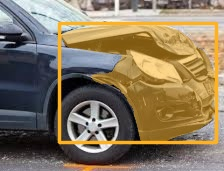

 Cost Estimate Range for Wreck Repair: Min:414 USD - Max:6896 USD


KeyboardInterrupt: ignored

In [ ]:
from google.colab import files
from IPython.display import Image, display
import time
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from ultralytics import YOLO
from IPython.display import Image, display
from google.colab import files
import glob
import time


def load_yolo_model(model_path='yolov8l.pt'):
    # Load YOLOv8n model
    model = YOLO(model_path)
    return model

#Lower confidence threshold to find more objects and detect cars in background
def perform_detection(model, image_path,class_id_to_detect=2, confidence_threshold=0.6):
    class_id = None
    box_height = None
    mask = None
    print("**\033[1m Performing detection on image:**")
    print("------------------------------------------")
    #Segment to get total car pixels in image
    model1=YOLO('yolov8n-seg.pt')
    results_seg = model1.predict(image_path, conf=.25,show_conf=True,show_labels=True, save=True)


    for r in results_seg:
        mask=np.sum(r.masks.xy[0])

    results = model.predict(image_path, conf=confidence_threshold,classes=2,show_conf=True,show_labels=True,save_crop=True, save=True)
    for i, result in enumerate(results):
        for box in result.boxes:
            class_id = int(box.cls[0])  # Convert the float class ID to an integer
            conf = box.conf[0].item()
            box = box.xyxy[0].tolist()
            #print("Entire box coords:", box)
            #print("Height:",box[3])
            #print("Class ID:", class_id)  # Print the class ID for each box
            if class_id == class_id_to_detect:
                print("**\033[1m Car detected in image")
                print("------------------------------")
                #print("\033[1m Car detected in image",conf)
                box_height = box[3]  # Return the result if the specified class ID is detected in any box
                break

    return class_id, box_height, mask



def load_classification_model(model_path='/content/drive/MyDrive/Yolov8_Metrics/trained_class_model_softmax.h5'):
    # Load the classification model
    print("**\033[1m Loading classification model**")
    print("-----------------------------------------")

    model = tf.keras.models.load_model(model_path)
    return model

def classify_image(model, class_labels, img_height=500, img_width=500):
    # Set the threshold to 0.3
    threshold = 0.3
    # Find the latest directory created with 'predict' in its name
    latest_directory = max(glob.glob('/content/runs/detect/predict*'), key=os.path.getctime)

    crops_directory = os.path.join(latest_directory, 'crops', 'car')

    image_paths = glob.glob(os.path.join(crops_directory, '*.jpg'))
     # Check if there are any images
    if not image_paths:
        print("No images found.")
        return

    # Get the first image path from the list
    image_path = image_paths[0]

    # Load and preprocess the single image
    print("**\033[1m Classifying image:**")
    print("------------------------------")

    img = image.load_img(image_path, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0

    # Get the predicted probabilities for each class
    predictions = model.predict(img)
    predicted_probability = predictions[0][0]  # Probability for class 0 ("damage")

    # Determine the predicted class label based on the threshold for "damage" (class 0)
    if predicted_probability >= threshold:
        predicted_class_label = class_labels[0]  # Class 0 corresponds to "damage"
    else:
        predicted_class_label = class_labels[1]  # Class 1 corresponds to "not damaged"

    # Return the predicted label and probability as strings
    return predicted_class_label, predicted_probability



def segment_image( model_path='/content/drive/MyDrive/Yolov8_Metrics/best.pt', confidence_threshold=0.25):
    # Perform segmentation on an image

    %cd {HOME}
    latest_directory = max(glob.glob('/content/runs/detect/predict*'), key=os.path.getctime)

    crops_directory = os.path.join(latest_directory, 'crops', 'car')
    source_image = glob.glob(os.path.join(crops_directory, '*.jpg'))
    if not source_image:
        print("No images found.")
        return


    source_image = source_image[0]
    #Define the source image path
    #source_image = image_path
    #print("Source image",source_image)
    print("**\033[1m Performing segmentation on image:**")
    print("---------------------------------------------")

  # Load a pretrained YOLOv8n model
    model = YOLO('/content/drive/MyDrive/Yolov8_Metrics/best.pt')


    results = model.predict(f'{source_image}',conf=.15,show_labels=False, show_conf=False,save=True,)
    for r in results:
        mask=np.sum(r.masks.xy[0])
        #mask_n=np.sum(r.masks.xyn)

        #print("Coords:",mask)
        #print("Normalized: ",mask_n)



    # Perform segmentation on the image

    #!yolo task=segment mode=predict model=/content/drive/MyDrive/Yolov8_Metrics/best.pt conf={confidence_threshold} source={source_image} save_txt=True save=true

    # Find the latest directory created with 'predict' in its name
    latest_directory = max(glob.glob('/content/runs/segment/predict*'), key=os.path.getctime)

    # Find the segmented image within the latest directory
    segmented_image_path = glob.glob(os.path.join(latest_directory, '*.jpg'))[0]

   # Define a dictionary to map class_id to damage detection messages
    damage_messages = {
        1: "\033[1m Damage detected: Dent",
        2: "\033[1m Damage detected: Broken Glass",
        3: "\033[1m Damage detected: Wreck",
        4: "\033[1m Damage detected: Scratch",
    }

    # Iterate through the results and print class ID and damage message for each instance
    for i, result in enumerate(results):
        for box in result.boxes:
            class_id = int(box.cls[0])
            # Print the class ID and corresponding damage message
            print(f"\033[1m Instance {i+1}, {damage_messages.get(class_id, 'Unidentifiable Damage')}")

    # Return the path of the segmented image

    return segmented_image_path,mask,class_id



# Define class labels
class_labels = ["00-damaged", '01-whole']

while True:
    # Ask if the user wants to upload an image
    #another_image = input("Do you want to upload an image? (jpg only for now) (y/n): ").strip().lower()

    #if another_image != 'y':
     #   break  # Exit the loop if the user does not want to upload an image

    # Upload an image
    uploaded = files.upload()

    # Check if an image was uploaded
    if len(uploaded) == 0:
        print("No image uploaded.")
        continue

    # Get the first uploaded image
    uploaded_image_path = list(uploaded.keys())[0]

    # Load YOLO model
    yolo_model = load_yolo_model()

    # Perform object detection
    detection_result,detection_box_height,mask_area = perform_detection(yolo_model, uploaded_image_path)

    # Perform classification
    if detection_result == 2:
        # Classify the image
        classification_model = load_classification_model()
        class_label, probability = classify_image(classification_model, class_labels)
        #print("Class label:", class_label)
        #print("Probability:", probability)

        if class_label == "00-damaged":
            #Perform segmentation if the image is classified as "damaged"
            segmentation_result_image_path,mask,class_id = segment_image()
            #print(mask_area+detection_box_height)
            display(Image(filename=segmentation_result_image_path, height=600))


            # Define the real-world dimensions for the car (average width and height)
            real_width_ft = 14.7  # feet
            real_height_ft = 5.8  # feet

            # Calculate the total car area in square feet
            total_car_area_sqft = (mask / real_width_ft) * (mask / real_height_ft)

            # Calculate the damage area in square feet
            damage_area_sqft = (mask_area/ real_width_ft) * (mask_area / real_height_ft)

            # Calculate the percentage of damage in square feet
            damage_percentage_sqft = (damage_area_sqft / total_car_area_sqft)
            #print("%",damage_percentage_sqft)


              # Define cost ranges for each class
            cost_ranges = {

                  1: (50, 2500),    # Dent
                  2: (100, 400),    # Broken Glass
                  3: (600, 10000),  # Wreck
                  4: (250, 2000),   # Scratch

              }

              # Check if the class_id is in the dictionary
            if class_id in cost_ranges:
                  min_cost_estimate, max_cost_estimate = cost_ranges[class_id]
                  # Print the cost estimate range based on the class ID
                   # Calculate cost estimates by multiplying with percentage_damage
                  min_cost_estimate *=  damage_percentage_sqft
                  max_cost_estimate *=  damage_percentage_sqft

                  class_names = {
                      1: "Dent",
                      2: "Broken Glass",
                      3: "Wreck",
                      4: "Scratch",

                  }
                  print(f"\033[1m Cost Estimate Range for {class_names[class_id]} Repair: Min:{round(min_cost_estimate)} USD - Max:{round(max_cost_estimate)} USD")
            else:
                  print("Unknown class_id:", class_id)

             # percentage_damage_diff = (mask_area/mask)
            # print("Percentage of Damage of the car in the image:", percentage_damage_diff)

        else:
            print("\033[1m No clear damage detected. Please upload a clear image")
    else:
        print("\033[1m No car detected in the image. Please upload a clear image")

    # Ask if the user wants to process another image
    another_image = input("\033[1m Do you want to process another image? (y/n): ").strip().lower()

    if another_image != 'y':
      break  # Exit the loop if the user does not want to process another image
